<a href="https://colab.research.google.com/github/MarioAuditore/TDA-for-Travelling-Salesman/blob/main/train_tsp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Based on "The Transformer Network for the Traveling Salesman Problem"

Xavier Bresson, Thomas Laurent, Feb 2021<br>

Arxiv : https://arxiv.org/pdf/2103.03012.pdf<br>
Talk : https://ipam.wistia.com/medias/0jrweluovs<br>
Slides : https://t.co/ySxGiKtQL5<br>

This code trains the transformer network by reinforcement learning.<br>
Use the beam search code to test the trained network.


In [ ]:
!git clone https://github.com/MarioAuditore/TDA-for-Travelling-Salesman.git

In [ ]:
import os

os.chdir('/content/TDA-for-Travelling-Salesman')

In [ ]:
!pip install 'pyconcorde @ git+https://github.com/jvkersch/pyconcorde'

In [ ]:
# ================
# Libs
# ================

import torch
import torch.nn as nn
from tqdm import tqdm

# Models
from tsp_transformer.model import TSP_net, compute_tour_length


import time
import argparse
import os
import datetime


# visualization
%matplotlib inline
# from IPython.display import set_matplotlib_formats, clear_output
# set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd


import networkx as nx
from scipy.spatial.distance import pdist, squareform
from concorde.tsp import TSPSolver # !pip install -e pyconcorde


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
###################
# Hardware : CPU / GPU(s)
###################

if torch.backends.mps.is_available():
    gpu_id = '0'
    device = torch.device("mps")

elif torch.cuda.is_available():
    gpu_id = '0' # select a single GPU
    # gpu_id = '2,3' # select multiple GPUs
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))

else:
    device = torch.device("cpu")
    gpu_id = -1 # select CPU


print(device)

mps


In [ ]:
# ================
# Hyper-parameters
# ================

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

args = DotDict()
args.gpu_id = gpu_id

# TSP problem number of nodes
args.nb_nodes = 10 # TSP10
# args.nb_nodes = 20 # TSP20

# Transformer parameters
args.dim_emb = 128 # dimension of embeddings in transformer
args.dim_ff = 512 # dimension of feed forward layers
args.dim_input_nodes = 2 # dimension of input features
args.nb_layers_encoder = 6
args.nb_layers_decoder = 2
args.nb_heads = 8

#
args.nb_epochs = 20 # number of epochs
args.batch_size = 128 # batch size
args.nb_batch_per_epoch = 250 # number of batches to generate on each epoch for training
args.nb_batch_eval = 100 # number of batches to generate on each epoch for evaluation
args.lr = 1e-4 # optimiser lr
args.tol = 1e-3 # model should perform better w.r.t tolerance to be updated
args.batchnorm = True  # if batchnorm=True  than batch norm is used
# args.batchnorm = False # if batchnorm=False than layer norm is used
args.max_len_PE = 1000

print(args)


{'gpu_id': '0', 'nb_nodes': 10, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 20, 'batch_size': 128, 'nb_batch_per_epoch': 250, 'nb_batch_eval': 100, 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}


# Training
## Setup

In [ ]:
###################
# Instantiate a training network and a baseline network
###################
try:
    del model_train # remove existing model
    del model_baseline # remove existing model
except:
    pass

model_train = TSP_net(args.dim_input_nodes,
                      args.dim_emb,
                      args.dim_ff,
                      args.nb_layers_encoder,
                      args.nb_layers_decoder,
                      args.nb_heads,
                      args.max_len_PE,
                      batchnorm=args.batchnorm)

model_baseline = TSP_net(args.dim_input_nodes,
                         args.dim_emb,
                         args.dim_ff,
                         args.nb_layers_encoder,
                         args.nb_layers_decoder,
                         args.nb_heads,
                         args.max_len_PE,
                         batchnorm=args.batchnorm)

if torch.cuda.device_count() > 1:
    print(torch.cuda.device_count() + " cuda devices found, doing parallel training.")
    model_train = nn.DataParallel(model_train)
    model_baseline = nn.DataParallel(model_baseline)

optimizer = torch.optim.Adam(model_train.parameters(), lr = args.lr)

model_train = model_train.to(device)
model_baseline = model_baseline.to(device)
model_baseline.eval()

print(args); print('')

# Logs
os.system("mkdir logs")
time_stamp=datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S")
file_name = 'logs'+'/'+time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id) + ".txt"
file = open(file_name,"w",1)
file.write(time_stamp+'\n\n')
for arg in vars(args):
    file.write(arg)
    hyper_param_val="={}".format(getattr(args, arg))
    file.write(hyper_param_val)
    file.write('\n')
file.write('\n\n')
plot_performance_train = []
plot_performance_baseline = []
all_strings = []
epoch_ckpt = 0
tot_time_ckpt = 0


# # Uncomment these lines to re-start training with saved checkpoint
# ====================================================================
# checkpoint_file = "checkpoint/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl"
# checkpoint = torch.load(checkpoint_file, map_location=device)
# epoch_ckpt = checkpoint['epoch'] + 1
# tot_time_ckpt = checkpoint['tot_time']
# plot_performance_train = checkpoint['plot_performance_train']
# plot_performance_baseline = checkpoint['plot_performance_baseline']
# model_baseline.load_state_dict(checkpoint['model_baseline'])
# model_train.load_state_dict(checkpoint['model_train'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
# del checkpoint
# ====================================================================



{'gpu_id': '0', 'nb_nodes': 10, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 20, 'batch_size': 128, 'nb_batch_per_epoch': 250, 'nb_batch_eval': 100, 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}



mkdir: logs: File exists


## Test
### Best solution

In [ ]:
from joblib import Parallel, delayed

create_checkpoint = False
test_size = 1000
n_nodes = args.nb_nodes

if create_checkpoint:
    x = torch.rand(test_size, n_nodes, args.dim_input_nodes, device='cpu')

    def best_path(points):
        solution = TSPSolver.from_data(points[:, 0], points[:, 1], norm='GEO').solve(verbose=False)
        return compute_tour_length(points[None, :], solution.tour[None, :]).to('cpu')

    lengths = Parallel(n_jobs=-1)(delayed(best_path)(points) for points in x)

    best_length_mean = torch.tensor(lengths).mean()

    data_dir = os.path.join("data")
    torch.save({ 'x': x, 'mean': best_length_mean}, '{}.pkl'.format(data_dir + f"/{test_size}tsp{n_nodes}"))

### TSP tasks as validation checkpoints

In [ ]:
###################
# Small test set for quick algorithm comparison
# Note : this can be removed
###################

checkpoint = None

if args.nb_nodes==10 : checkpoint = torch.load("data/1000tsp10.pkl")
if args.nb_nodes==20 : checkpoint = torch.load("data/1000tsp20.pkl")

if checkpoint is not None:
    x_test_tsp = checkpoint['x'].to(device)
    x_test_len = checkpoint['mean']
    n = x_test_tsp.size(1)
    print(f'nb of nodes : {n} | mean length: {x_test_len}')
else:
    x_test_tsp = torch.rand(test_size, args.nb_nodes, args.dim_input_nodes, device='cpu')
    x_test_len = 1e-7
    n = x_test_tsp.size(1)
    print('nb of nodes :',n)

nb of nodes : 10 | mean length: 2.882951259613037


## Training loop

In [ ]:
###### ==================
# Main training loop
# ==================


start_training_time = time.time()

for epoch in tqdm(range(0, args.nb_epochs)):

    # re-start training with saved checkpoint
    # epoch += epoch_ckpt

    # -------------------------
    # Train model for one epoch
    # -------------------------
    start = time.time()
    model_train.train()

    for step in range(1, args.nb_batch_per_epoch + 1):

        # generate a batch of random TSP instances
        x = torch.rand(args.batch_size, args.nb_nodes, args.dim_input_nodes, device=device) # size(x)=(batch_size, nb_nodes, dim_input_nodes)

        # generate topological features
        # new_f = ...
        data = x # np.concat(x, new_f)

        # compute tours for model
        tour_train, sumLogProbOfActions = model_train(data, deterministic=False) # size(tour_train)=(batch_size, nb_nodes), size(sumLogProbOfActions)=(batch_size)

        # compute tours for baseline
        with torch.no_grad():
            tour_baseline, _ = model_baseline(data, deterministic=True)

        # get the lengths of the tours
        L_train = compute_tour_length(x, tour_train) # size(L_train)=(batch_size)
        L_baseline = compute_tour_length(x, tour_baseline) # size(L_baseline)=(batch_size)

        # backprop
        loss = torch.mean((L_train - L_baseline) * sumLogProbOfActions )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    time_one_epoch = time.time()-start
    time_tot = time.time()-start_training_time + tot_time_ckpt


    # -----------------
    # Evaluate train model and baseline on 10k random TSP instances
    # -----------------
    model_train.eval()
    mean_tour_length_train = 0
    mean_tour_length_baseline = 0

    for step in range(0, args.nb_batch_eval):
        # generate a batch of random tsp instances
        x = torch.rand(args.batch_size, args.nb_nodes, args.dim_input_nodes, device=device)

        # generate topological features
        # new_f = ...
        data = x # np.concat(x, new_f)

        # compute tour for model and baseline
        with torch.no_grad():
            tour_train, _ = model_train(data, deterministic=True)
            tour_baseline, _ = model_baseline(data, deterministic=True)

        # get the lengths of the tours
        L_train = compute_tour_length(x, tour_train)
        L_baseline = compute_tour_length(x, tour_baseline)

        # L_tr and L_bl are tensors of shape (batch_size,). Compute the mean tour length
        mean_tour_length_train += L_train.mean().item()
        mean_tour_length_baseline += L_baseline.mean().item()

    mean_tour_length_train =  mean_tour_length_train/ args.nb_batch_eval
    mean_tour_length_baseline =  mean_tour_length_baseline/ args.nb_batch_eval

    # evaluate train model and baseline and update if train model is better
    update_baseline = mean_tour_length_train + args.tol < mean_tour_length_baseline
    if update_baseline:
        model_baseline.load_state_dict(model_train.state_dict())

    # For new baseline compute TSPs for small test set
    with torch.no_grad():
        tour_baseline, _ = model_baseline(x_test_tsp.to(device), deterministic=True)
    mean_tour_length_test = compute_tour_length(x_test_tsp, tour_baseline.to('cpu')).mean().item()

    # For checkpoint
    plot_performance_train.append([(epoch+1), mean_tour_length_train])
    plot_performance_baseline.append([(epoch+1), mean_tour_length_baseline])

    # Compute TSPs for small test set
    with torch.no_grad():
        tour_baseline, _ = model_baseline(x_test_tsp, deterministic=True)
    mean_tour_length_test = compute_tour_length(x_test_tsp, tour_baseline).mean().item()

    # Compute optimality gap
    gap_train = mean_tour_length_test / x_test_len - 1.0


    # Print and save in txt file
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_train: {:.3f}, L_base: {:.3f}, L_test: {:.3f}, gap_train(%): {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_train, mean_tour_length_baseline, mean_tour_length_test, 100*gap_train, update_baseline)
    print(mystring_min) # Comment if plot display

    # all_strings.append(mystring_min) # Uncomment if plot display
    # for string in all_strings:
    #     print(string)

    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'TSP_length': [torch.mean(L_train).item(), torch.mean(L_baseline).item(), mean_tour_length_test],
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'mean_tour_length_test': mean_tour_length_test,
        'model_baseline': model_baseline.state_dict(),
        'model_train': model_train.state_dict(),
        'optimizer': optimizer.state_dict(),
        }, '{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id)))



  5%|███▎                                                              | 1/20 [00:44<13:57, 44.08s/it]

Epoch: 0, epoch time: 0.614min, tot time: 0.000day, L_train: 2.946, L_base: 3.770, L_test: 2.964, gap_train(%): 2.825, update: True


 10%|██████▌                                                           | 2/20 [01:25<12:50, 42.78s/it]

Epoch: 1, epoch time: 0.593min, tot time: 0.001day, L_train: 2.913, L_base: 2.951, L_test: 2.923, gap_train(%): 1.385, update: True


 15%|█████████▉                                                        | 3/20 [02:07<11:57, 42.21s/it]

Epoch: 2, epoch time: 0.583min, tot time: 0.001day, L_train: 2.905, L_base: 2.912, L_test: 2.916, gap_train(%): 1.136, update: True


 20%|█████████████▏                                                    | 4/20 [02:48<11:08, 41.78s/it]

Epoch: 3, epoch time: 0.580min, tot time: 0.002day, L_train: 2.904, L_base: 2.907, L_test: 2.913, gap_train(%): 1.049, update: True


 25%|████████████████▌                                                 | 5/20 [03:29<10:20, 41.39s/it]

Epoch: 4, epoch time: 0.573min, tot time: 0.002day, L_train: 2.903, L_base: 2.904, L_test: 2.911, gap_train(%): 0.986, update: True


 30%|███████████████████▊                                              | 6/20 [04:10<09:38, 41.32s/it]

Epoch: 5, epoch time: 0.577min, tot time: 0.003day, L_train: 2.896, L_base: 2.895, L_test: 2.911, gap_train(%): 0.986, update: False


 35%|███████████████████████                                           | 7/20 [04:52<08:58, 41.43s/it]

Epoch: 6, epoch time: 0.588min, tot time: 0.003day, L_train: 2.903, L_base: 2.903, L_test: 2.911, gap_train(%): 0.986, update: False


 35%|███████████████████████                                           | 7/20 [05:13<09:42, 44.77s/it]


KeyboardInterrupt: 

## Final check on test data

In [ ]:
# generate topological features
# new_f = ...
data = x_test_tsp # np.concat(x_test_tsp, new_f)

with torch.no_grad():
    tour_baseline, _ = model_baseline(data, deterministic=True)
    print(compute_tour_length(x_test_tsp, tour_baseline).mean().to('cpu'), x_test_len)

tensor(2.9114) tensor(2.8830)


# Visualisation
Graphs should be fixed

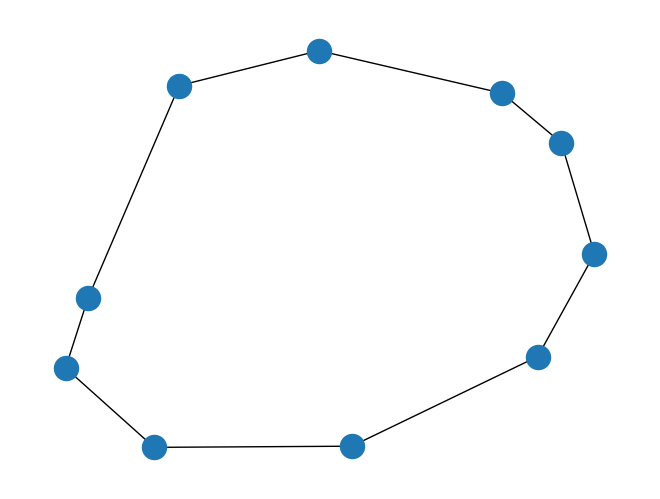

In [ ]:
from scipy.spatial import distance_matrix


idx = 0
points = np.array(x_test_tsp[idx].to('cpu'))

dist_mtx = distance_matrix(points, points)
model_tour = np.array(tour_baseline[idx].to('cpu'))

def create_graph(tour, dist_mtx):
    mask = np.zeros_like(dist_mtx)

    for i in range(-1, len(tour) - 1):
        point_a = tour[i]
        point_b = tour[i + 1]
        mask[point_a, point_b] = 1
    return nx.from_numpy_matrix(mask * dist_mtx)

G = create_graph(model_tour, dist_mtx)
pos = nx.spring_layout(G, seed=47)  # Seed layout for reproducibility
nx.draw(G)
plt.show()

In [ ]:
concorde_tour = TSPSolver.from_data(points[:, 0], points[:, 1], norm='GEO').solve(verbose=False).tour

Problem Name: a787c62b651c45ef8264bb247406b01a
Problem Type: TSP
Number of Nodes: 10
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


linkern ...
Setting kick type to close
Starting Cycle: 558
   0 Steps   Best: 511   0.00 seconds
   5 Total Steps.
Best cycle length: 511
Lin-Kernighan Running Time: 0.00
LK Initial Run: 511.0
LK Run 0: 511.0
LK Run from best tour: 511.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 511 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 418.000000  (0.00 seconds)
  LP Value  2: 502.000000  (0.00 seconds)
  LP Value  3: 511.000000  (0.00 seconds)
New lower bound: 511.000000
Exact lower bound: 511.000000
DIFF: 0.000000
Established Bound: 511
Optimal tour: 511
Total Time to solve TSP: 0.00


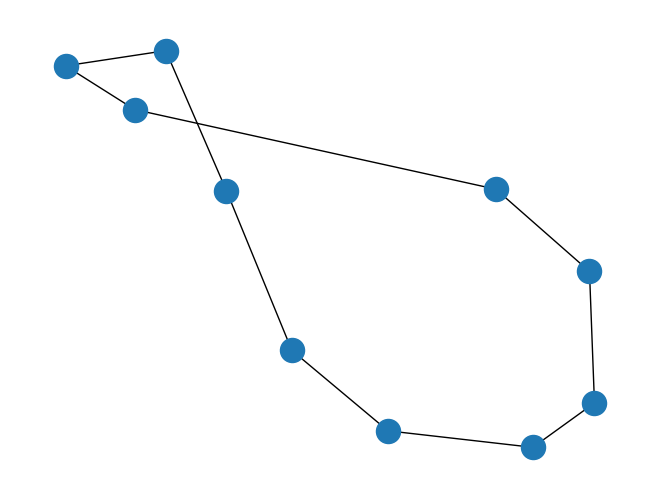

In [ ]:
G = create_graph(concorde_tour, dist_mtx)
pos = nx.spring_layout(G, seed=47)  # Seed layout for reproducibility
nx.draw(G)
plt.show()